<a href="https://colab.research.google.com/github/Kshitez-Pratap-Singh/AMP-Crypto-Arima/blob/main/To_work_AMP_Arima_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import yfinance as yf
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
end_date = datetime.today().strftime('%Y-%m-%d')
df = yf.download('AMP-USD', start='2005-09-15', end=end_date,interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-11,0.009530,0.011155,0.009429,0.011155,0.011155,339581
2020-09-12,0.011153,0.012090,0.011080,0.011844,0.011844,201512
2020-09-13,0.011845,0.012048,0.011210,0.011423,0.011423,311292
2020-09-14,0.011438,0.012304,0.011047,0.012011,0.012011,172603
2020-09-15,0.012011,0.012408,0.010927,0.011135,0.011135,913609
2020-09-16,0.011245,0.011254,0.009769,0.009894,0.009894,751176
2020-09-17,0.009903,0.010191,0.008771,0.008862,0.008862,256191
2020-09-18,0.008860,0.008895,0.007350,0.007892,0.007892,600481
2020-09-19,0.007892,0.008826,0.007815,0.008797,0.008797,439767


In [ ]:
df.shape

(1237, 6)

In [ ]:
df.drop('Close', axis=1,inplace=True)

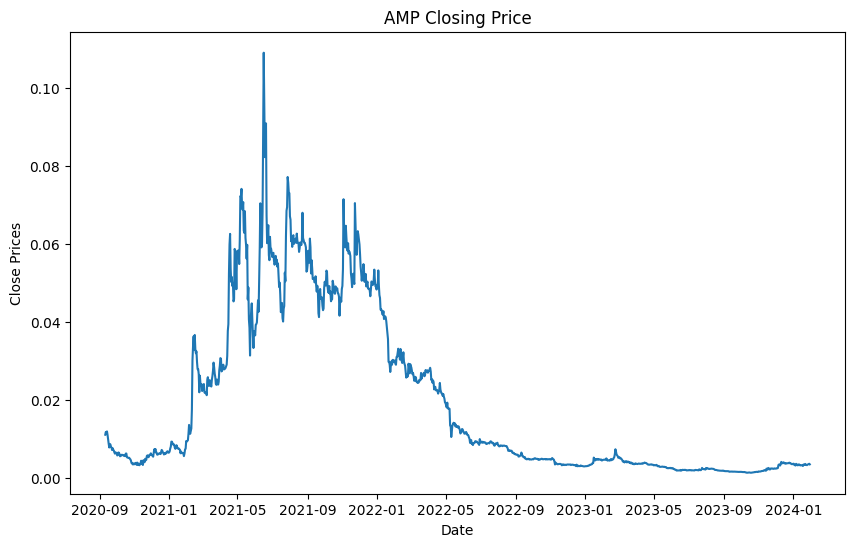

In [ ]:
#plot close price
#from matplotlib.pyplot import figure
#plt.figure(figsize=(50,20))
#plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Adj Close'])
plt.title('AMP Closing Price')
plt.show()

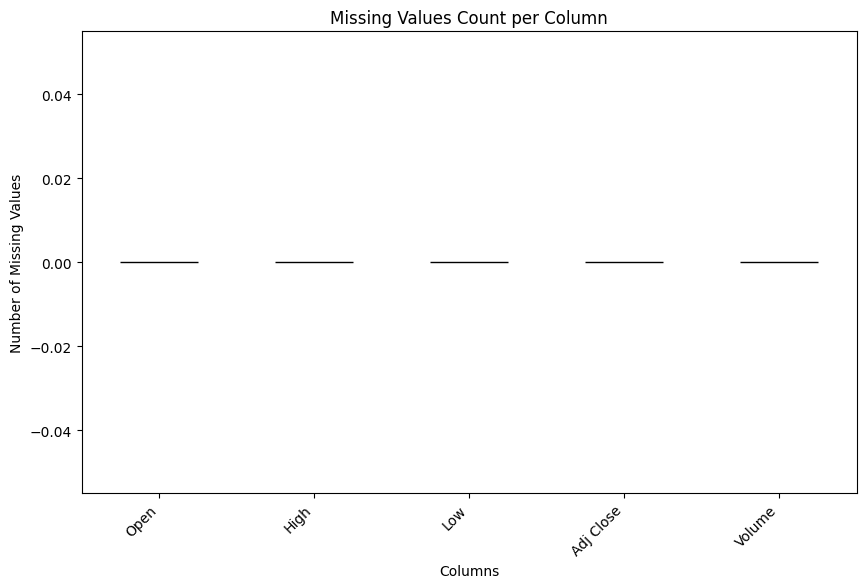

In [ ]:
missing_values = df.isnull().sum()

plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Missing Values Count per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()

<Axes: >

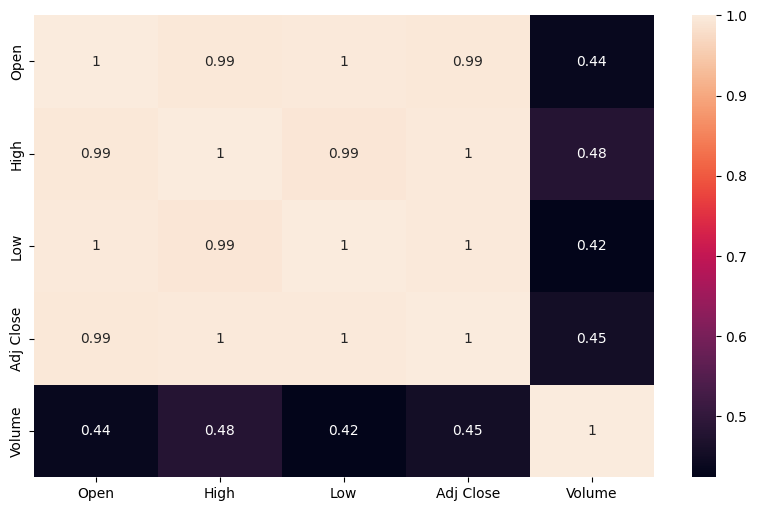

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True)

In [ ]:
corr_matrix = df.corr()['Adj Close']
corr_matrix

Open         0.994380
High         0.996798
Low          0.996032
Adj Close    1.000000
Volume       0.454102
Name: Adj Close, dtype: float64

<Axes: ylabel='Density'>

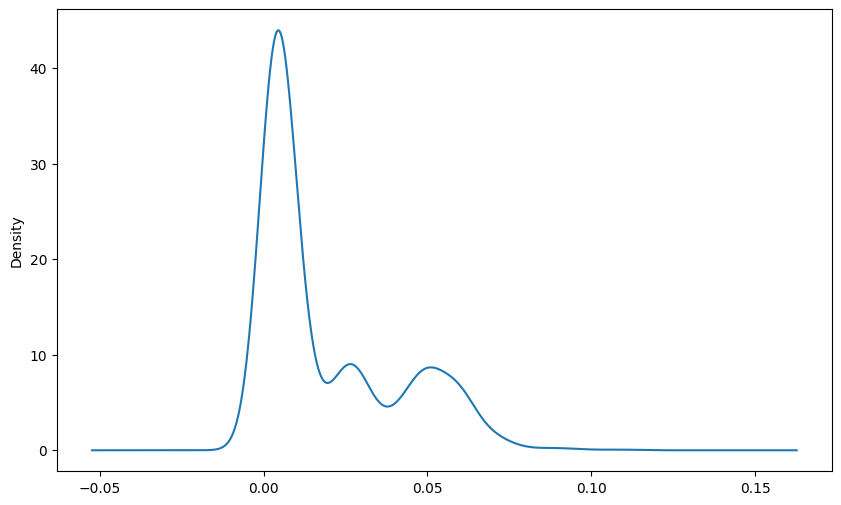

In [ ]:
#Distribution of the dataset
df['Adj Close'].plot(kind='kde')

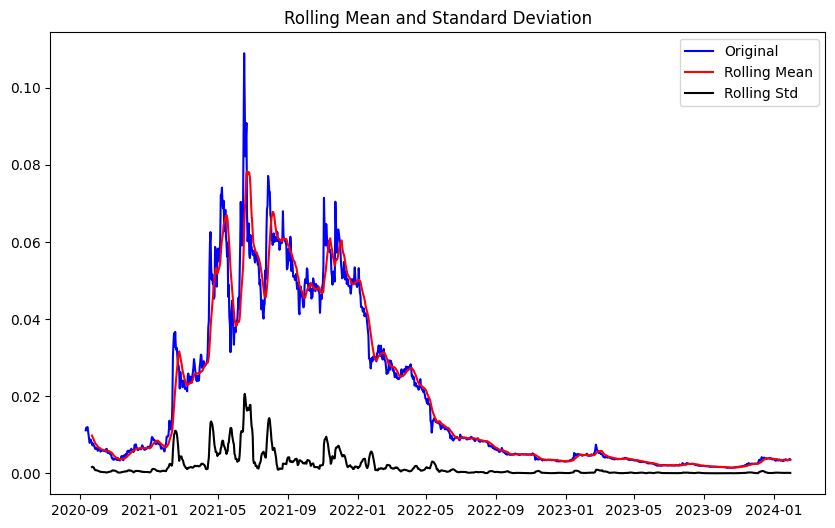

Results of dickey fuller test
Test Statistics                  -1.282641
p-value                           0.637076
No. of lags used                 18.000000
Number of observations used    1218.000000
critical value (1%)              -3.435730
critical value (5%)              -2.863916
critical value (10%)             -2.568035
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df['Adj Close'])

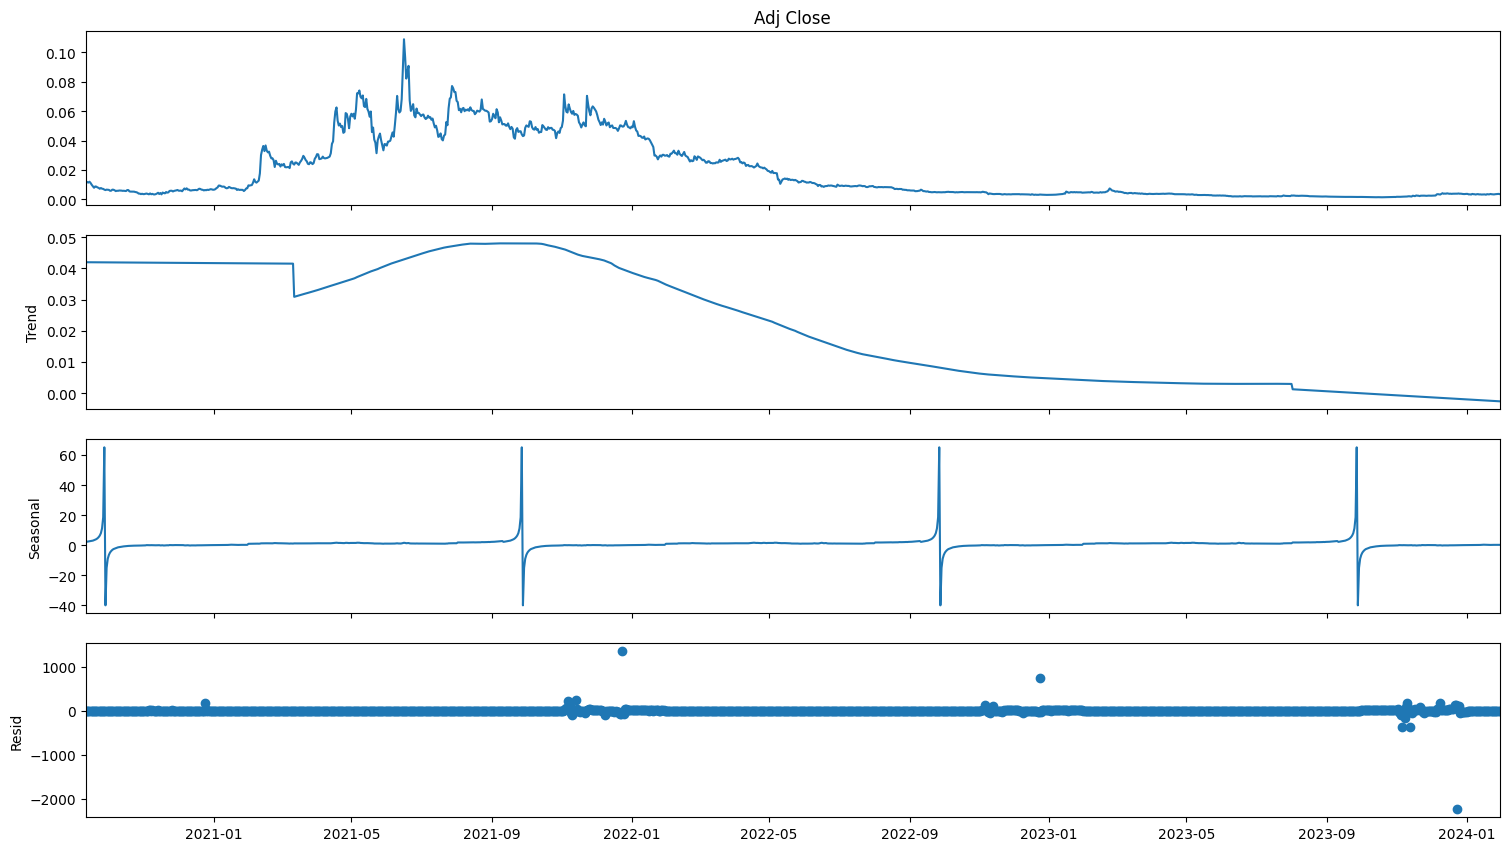

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative Decomposition
decomp_mul = seasonal_decompose(df['Adj Close'], model='multiplicative', extrapolate_trend='freq', period=365)
fig=decomp_mul.plot()
fig.set_size_inches(16, 9)

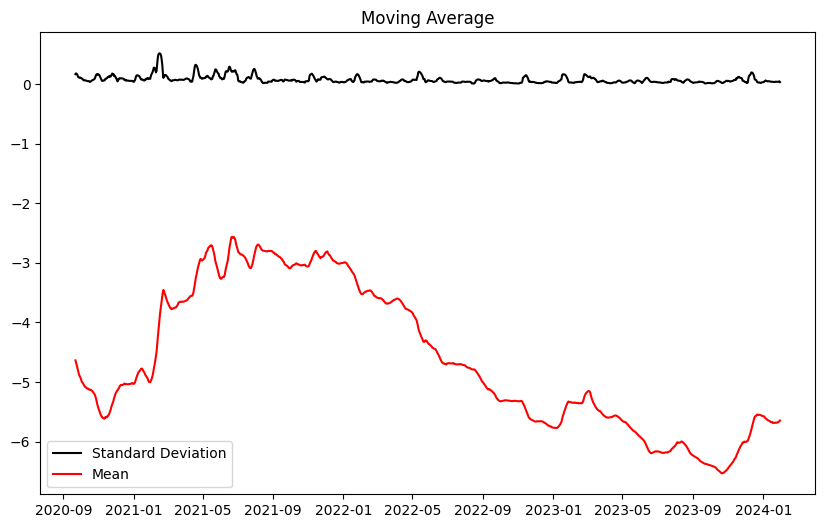

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Adj Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

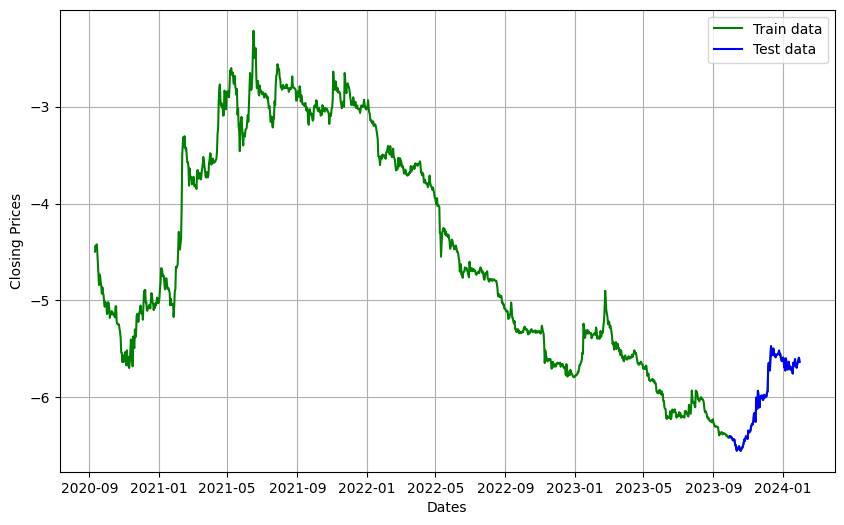

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2912.982, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2911.011, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2911.010, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2914.130, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2909.111, Time=1.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.850 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1110
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1458.065
Date:                Wed, 31 Jan 2024   AIC                          -2914.130
Time:                        12:18:13   BIC                          -2909.119
Sample:                    09-14-2020   HQIC                         -2912.235
                         - 09-28-2023                                  

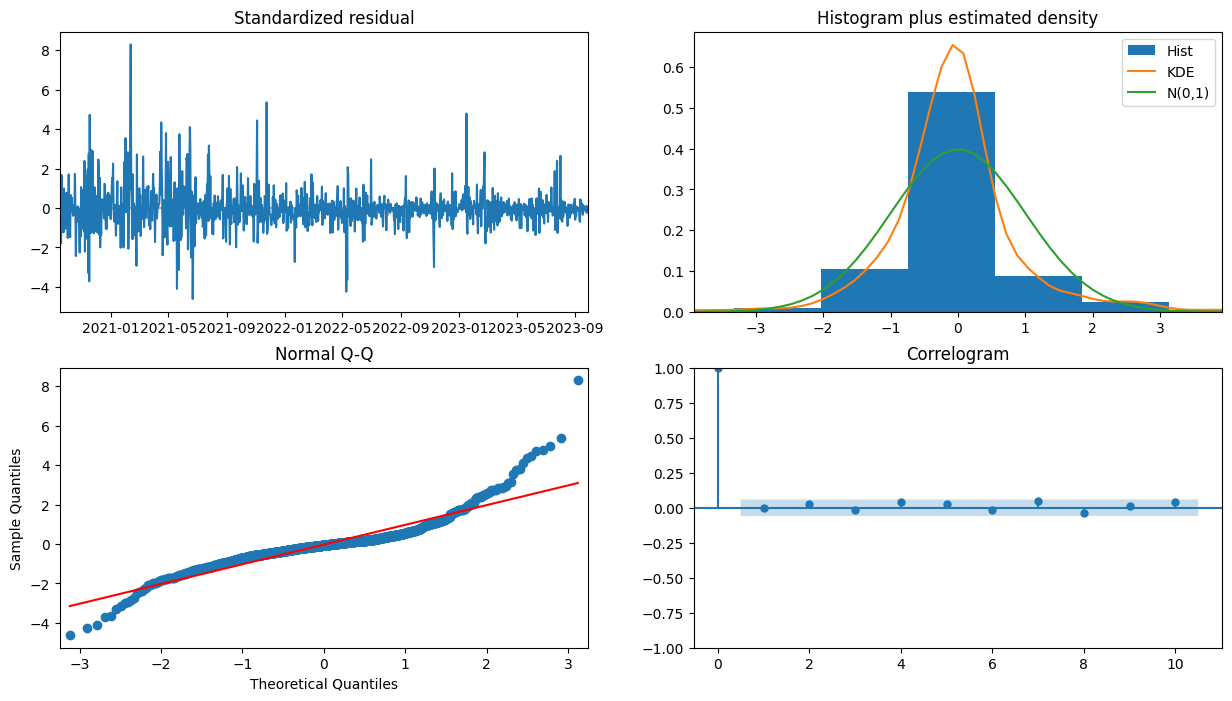

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
#Modeling
# Build Model
#import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(0,1,1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1110
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1458.075
Date:                Wed, 31 Jan 2024   AIC                          -2912.151
Time:                        12:18:14   BIC                          -2902.128
Sample:                    09-14-2020   HQIC                         -2908.361
                         - 09-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0042      0.016     -0.258      0.796      -0.036       0.028
sigma2         0.0042   8.27e-05     51.041      0.000       0.004       0.004
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
'''
# Forecast
forecast_length = len(test_data)
fc, se, conf = fitted.get_forecast(steps=forecast_length, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='gray', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
'''

"\n# Forecast\nforecast_length = len(test_data)\nfc, se, conf = fitted.get_forecast(steps=forecast_length, alpha=0.05)  # 95% conf\n\n# Make as pandas series\nfc_series = pd.Series(fc, index=test_data.index)\nlower_series = pd.Series(conf[:, 0], index=test_data.index)\nupper_series = pd.Series(conf[:, 1], index=test_data.index)\n\n# Plot\nplt.figure(figsize=(10, 5), dpi=100)\nplt.plot(train_data, label='Training Data')\nplt.plot(test_data, color='blue', label='Actual Stock Price')\nplt.plot(fc_series, color='orange', label='Predicted Stock Price')\nplt.fill_between(lower_series.index, lower_series, upper_series, color='gray', alpha=.10)\nplt.title('ARCH CAPITAL GROUP Stock Price Prediction')\nplt.xlabel('Time')\nplt.ylabel('ARCH CAPITAL GROUP Stock Price')\nplt.legend(loc='upper left', fontsize=8)\nplt.show()\n"

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


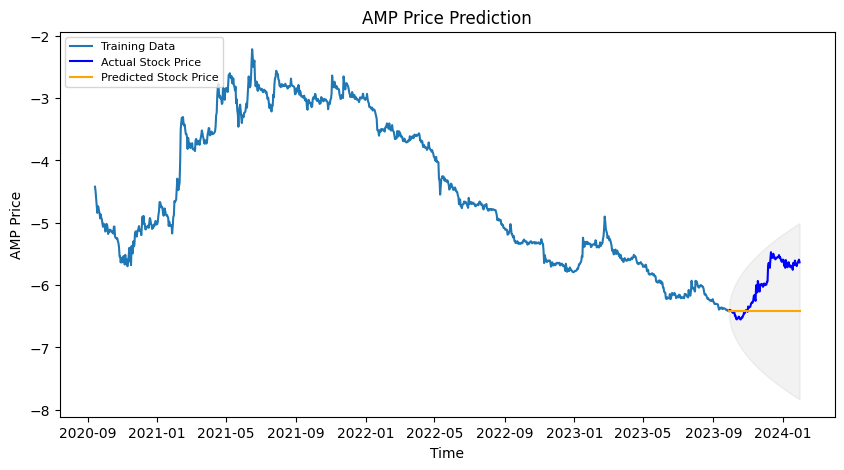

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_data' and 'test_data' are your training and test datasets

# Fit the ARIMA model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit()

# Forecast
forecast_length = len(test_data)
forecast = fitted.get_forecast(steps=forecast_length, alpha=0.05)  # 95% confidence interval

# Extracting predicted values and confidence intervals
fc_series = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series.index, fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.1)
plt.title('AMP Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMP Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
# Report performance
mse = mean_squared_error(test_data, fc_series)
print('MSE: {:.2f}'.format(mse))
mae = mean_absolute_error(test_data, fc_series)
print('MAE: {:.2f}'.format(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: {:.2f}'.format(rmse))
mape = np.mean(np.abs(fc_series - test_data) / np.abs(test_data)) * 100
print('MAPE: {:.2f}%'.format(mape))


MSE: 0.32
MAE: 0.46
RMSE: 0.57
MAPE: 8.05%


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


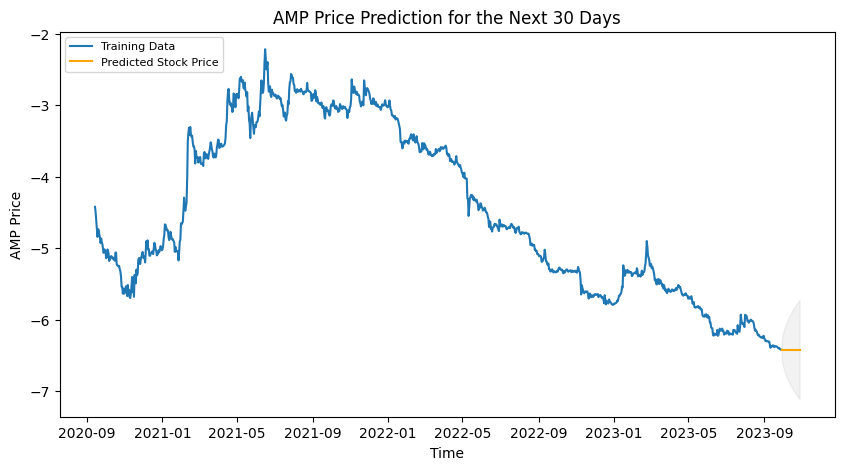

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_data' is your training dataset

# Fit the ARIMA model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit()

# Forecast for the next 30 days
forecast_steps = 30
forecast = fitted.get_forecast(steps=forecast_steps, alpha=0.05)  # 95% confidence interval

# Extracting predicted values and confidence intervals
fc_series = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(fc_series.index, fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.1)
plt.title('AMP Price Prediction for the Next 30 Days')
plt.xlabel('Time')
plt.ylabel('AMP Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


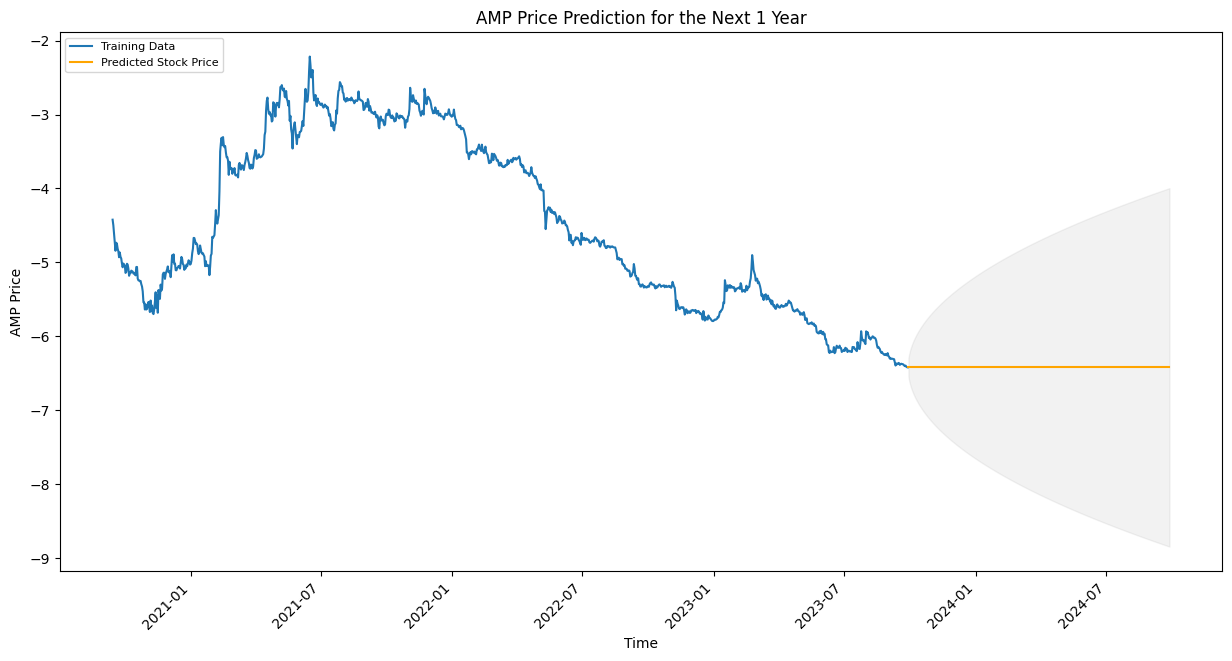

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_data' is your training dataset

# Fit the ARIMA model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit()

# Forecast for the next 1 year (365 days)
forecast_steps = 365
forecast = fitted.get_forecast(steps=forecast_steps, alpha=0.05)  # 95% confidence interval

# Extracting predicted values and confidence intervals
fc_series = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# Plot
plt.figure(figsize=(15, 7), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(fc_series.index, fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.1)
plt.title('AMP Price Prediction for the Next 1 Year')
plt.xlabel('Time')
plt.ylabel('AMP Price')
plt.legend(loc='upper left', fontsize=8)

# Tilt the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


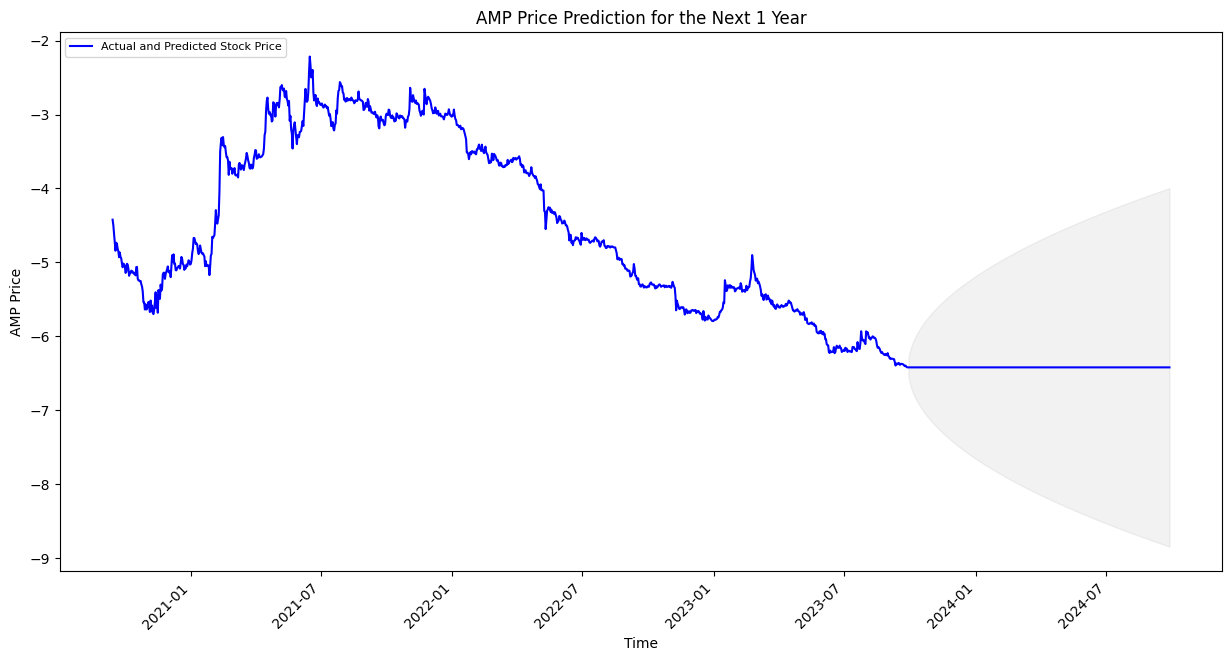

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_data' is your training dataset

# Fit the ARIMA model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit()

# Forecast for the next 1 year (365 days)
forecast_steps = 365
forecast = fitted.get_forecast(steps=forecast_steps, alpha=0.05)  # 95% confidence interval

# Concatenate the training data and forecasted series
combined_series = pd.concat([train_data, forecast.predicted_mean])

# Extracting confidence intervals
conf_int = forecast.conf_int(alpha=0.05)

# Plot
plt.figure(figsize=(15, 7), dpi=100)
plt.plot(combined_series.index, combined_series, label='Actual and Predicted Stock Price', color='blue')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.1)
plt.title('AMP Price Prediction for the Next 1 Year')
plt.xlabel('Time')
plt.ylabel('AMP Price')
plt.legend(loc='upper left', fontsize=8)

# Tilt the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()
